In [2]:
#Загружаем библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, LSTM 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

%matplotlib inline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
base_data = pd.read_csv('/content/drive/My Drive/datasets/date_csv/traff.csv')
base_data.head()

,1/1/2017,"22,226.00"
0,1/2/2017,"29,593.00"
1,1/3/2017,"31,726.00"
2,1/4/2017,"32,684.00"
3,1/5/2017,"31,820.00"
4,1/6/2017,"29,354.00"


In [4]:
# Убираем ненужную колонку с датой
base_data = base_data.iloc[:,1:]
base_data.columns = ['traff']
base_data.head()

,traff
0,"29,593.00"
1,"31,726.00"
2,"32,684.00"
3,"31,820.00"
4,"29,354.00"


In [5]:
# Удаляем ненужный символ ','
a = []
for i in range(len(base_data)):
    
    a.append(float(base_data['traff'][i].replace(',','')))

In [6]:
index = list(range(len(base_data)))
data = pd.DataFrame(a, columns = ['traff'], index = index)
data

,traff
0,29593.0
1,31726.0
2,32684.0
3,31820.0
4,29354.0
...,...
1089,29801.0
1090,34913.0
1091,37665.0
1092,32643.0


In [7]:
xLen = 60
valLen = 300 

trainLen = data.shape[0]-valLen 

xTrain,xTest = data[:trainLen], data[trainLen+xLen+2:]

xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

yTrain,yTest = np.reshape(data[:trainLen],(-1,1)), np.reshape(data[trainLen+xLen+2:],(-1,1)) 
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

trainDataGen = TimeseriesGenerator(xTrain, yTrain, 
                               length=xLen, sampling_rate=1, 
                               batch_size=20)                

testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=20)

In [8]:
print(xTrain.shape)
print(xTest.shape)
print(yTrain.shape)
print(yTest.shape)
print(trainDataGen[0][0].shape)
# print(testDataGen.shape)

(794, 1)
(238, 1)
(794, 1)
(238, 1)
(20, 60, 1)


In [9]:
def getPred(currModel, xVal, yVal, yScaler):

  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
def correlate(a, b):

  ma = a.mean() 
  mb = b.mean()
  mab = (a*b).mean() 
  sa = a.std() 
  sb = b.std() 
  
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

def showCorr(channels, corrSteps, predVal, yValUnscaled):
  for ch in channels:
    corr = []
    yLen = yValUnscaled.shape[0] 
    for i in range(corrSteps):
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] 

    for i in range(corrSteps):
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()





DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=len(xTest))
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
37/37 [==============================] - 69s 2s/step - loss: 14.4464 - val_loss: 1.8408
Epoch 2/10
37/37 [==============================] - 69s 2s/step - loss: 0.6940 - val_loss: 0.4491
Epoch 3/10
37/37 [==============================] - 69s 2s/step - loss: 0.0852 - val_loss: 0.1146
Epoch 4/10
37/37 [==============================] - 69s 2s/step - loss: 0.0455 - val_loss: 0.0186
Epoch 5/10
37/37 [==============================] - 72s 2s/step - loss: 0.0143 - val_loss: 0.0154
Epoch 6/10
37/37 [==============================] - 69s 2s/step - loss: 0.0116 - val_loss: 0.0078
Epoch 7/10
37/37 [==============================] - 69s 2s/step - loss: 0.0080 - val_loss: 0.0075
Epoch 8/10
37/37 [==============================] - 69s 2s/step - loss: 0.0072 - val_loss: 0.0058
Epoch 9/10
37/37 [==============================] - 69s 2s/step - loss: 0.0080 - val_loss: 0.0055
Epoch 10/10
37/37 [======================

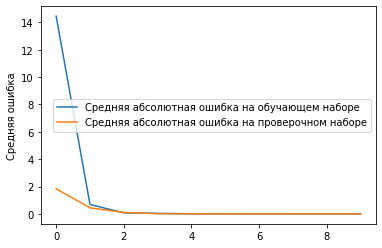

In [10]:
modelC = Sequential()

modelC.add(Conv1D(2048, 5, input_shape = (xLen,1), activation='linear'))
modelC.add(Flatten())
modelC.add(Dense(2048, activation='linear'))
modelC.add(Dense(1, activation='linear'))

modelC.compile(loss='mse', optimizer=Adam(lr=1e-4))

history = modelC.fit_generator(
                    trainDataGen,
                    epochs=10, verbose=1,
                    validation_data=testDataGen)

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

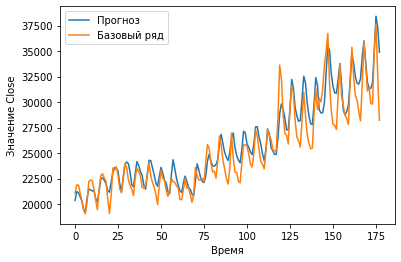

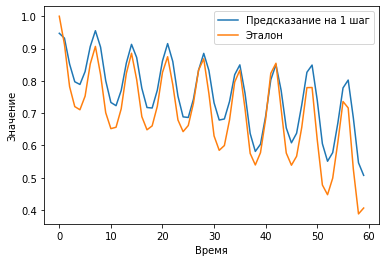

In [11]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)


showPredict(0, 4000, 0, predVal, yValUnscaled)

showCorr([0], 60, predVal, yValUnscaled)